In [1]:
# default_exp molmap.gene.distance

problems to be addressed:

1. the features have no categories
2. interactions between features obfuscates the original categories
3. the dimension reduction algorithms are applied to the wrong input

# molmap.gene

> Gene feature processing using MolMap

# Add feature sums

The data we have in mind is a $(N, M)$ matrix, with $N$ being the number of genes and $M$ the number of features.

Here we expand the features by calculating the sums of each two features, this will result in a $(N, M^2)$ matrix. 

and split 

In [2]:
import umap
import numpy as np
import pandas as pd
from lapjv import lapjv
from sklearn.metrics import pairwise_distances
from scipy.spatial.distance import squareform
from scipy.cluster.hierarchy import fcluster, linkage
import matplotlib.pyplot as plt
%config Completer.use_jedi = False

In [3]:

file_name = "/mnt/storage2/molmap_features/gene/input/CN-AML_log2expression-response.csv"

data_T = pd.read_csv(file_name, header = 0, index_col = 0)
data_T.shape

(268, 18533)

In [27]:
np.sum(np.arange(1, 18534))

171745311

In [4]:
data_T.head()

,DPM1,SCYL3,C1orf112,FGR,CFH,FUCA2,GCLC,NFYA,STPG1,NIPAL3,...,ARHGAP11B,LINC02795,HULC,RALY-AS1,ENSG00000285258,ENSG00000285399,GABPB1-IT1,PDGFRL2P,ENSG00000285441,response
GSM5033365,8.528089,8.618803,6.189037,8.480500,7.029838,8.788284,9.976258,7.974697,6.252231,8.826851,...,5.677537,3.582379,3.122948,7.145316,5.955838,8.540800,9.951084,6.077144,5.646510,0
GSM5033186,8.969203,8.672092,6.527113,11.208401,3.075902,8.506354,9.245827,8.459606,5.415752,8.504262,...,5.502166,2.776341,3.982792,6.388785,6.205185,8.426841,10.608258,6.152717,5.830789,0
GSM5033399,9.378293,8.609907,7.127125,10.546779,5.114741,9.245445,9.341568,9.799792,5.504687,8.102250,...,4.900616,0.256759,3.256760,6.234040,6.322849,8.354792,10.715167,5.163650,6.886116,1
GSM5033203,9.100713,9.080373,6.916288,7.916288,3.835368,7.354097,9.312348,8.712357,5.807354,8.059741,...,4.992910,3.942284,5.179323,6.065666,5.304854,8.243453,10.176588,5.304854,4.527246,1
GSM5033258,9.209079,7.988480,7.131674,11.877276,3.950344,10.172276,9.824228,8.705232,5.464917,7.982193,...,3.602421,2.950344,2.950344,5.897877,5.727952,7.917777,10.309152,4.666552,5.230452,1


In [5]:
#Feature Matrix and Y_true labels
dataX = data_T.drop(columns = "response")
dataY = data_T["response"]

In [6]:
#Feature variance sorting
VAR_list = np.var(dataX, axis = 0)
f_sorted = np.argsort(VAR_list)[::-1]
f_name = dataX.columns[f_sorted]

In [7]:
f_percentage = 0.01 #feature selection: (0,1], total number: 18532

In [8]:
f_num = round(f_percentage * len(f_name))
dataX = dataX.reindex(columns = f_name[:f_num])

In [9]:
dataX.shape

(268, 185)

In [10]:
x = dataX.values


In [11]:
x1 = (x[..., None] + x[:, None, :]) / 2
x1.shape

(268, 185, 185)

In [12]:
x2 = np.triu(x1).reshape(len(dataX), -1)
x2.shape

(268, 34225)

In [13]:
dataX = pd.DataFrame(x2, index=dataX.index)

In [14]:
dataX.shape

(268, 34225)

In [15]:
dataX = dataX.loc[:, (dataX != 0).any(axis=0)]
dataX.shape

(268, 17205)

In [16]:
np.sum(np.arange(1, 186))

17205

In [17]:
dataX = dataX.replace([np.nan, np.inf, -np.inf], 0)
distance_matrix = pairwise_distances(dataX.T, metric = 'cosine')

In [18]:
distance_matrix.shape

(17205, 17205)

## precomputing the pairewise distance

In [19]:
d = pairwise_distances(distance_matrix, metric='cosine')

In [20]:
reducer = umap.UMAP(
    n_neighbors = 30, 
    min_dist = 0.1, 
    n_components = 2, 
    metric = 'precomputed', 
    init='random', 
    random_state = 123)
embedding = reducer.fit_transform(d)

/home/ma/miniconda3/envs/molmap/lib/python3.7/site-packages/umap/umap_.py:1780: UserWarning: using precomputed metric; inverse_transform will be unavailable
  warn("using precomputed metric; inverse_transform will be unavailable")


In [21]:
embedding.shape

(17205, 2)

In [22]:
embedding[:5]

array([[-6.355319 , 15.34469  ],
       [ 3.3813012, 10.887586 ],
       [ 3.42659  , 10.845109 ],
       [ 3.831416 , 10.384565 ],
       [ 3.8210213, 10.487432 ]], dtype=float32)

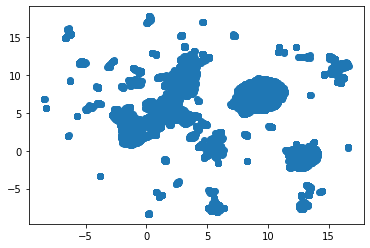

In [23]:
plt.scatter(embedding[:, 0], embedding[:, 1]);


## not precomputing the pairewise distance

In [24]:
reducer2 = umap.UMAP(
    n_neighbors = 30, 
    min_dist = 0.1, 
    n_components = 2, 
    metric='cosine', 
    init='random', 
    random_state = 123)
embedding2 = reducer.fit_transform(distance_matrix)
embedding2.shape

/home/ma/miniconda3/envs/molmap/lib/python3.7/site-packages/umap/umap_.py:1780: UserWarning: using precomputed metric; inverse_transform will be unavailable
  warn("using precomputed metric; inverse_transform will be unavailable")


(17205, 2)

In [25]:
embedding2[:5]

array([[ 2.9450164, 20.089283 ],
       [ 6.560175 , 12.468213 ],
       [ 6.54701  , 12.594105 ],
       [ 6.5758476, 12.5189905],
       [ 6.5498405, 12.490305 ]], dtype=float32)

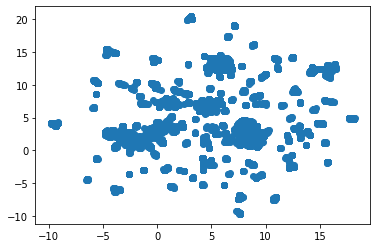

In [26]:
plt.scatter(embedding2[:, 0], embedding2[:, 1]);
